# Data Preprocessing

## 1. Introduction

Briefly describe the objectives of this notebook, which primarily focuses on preprocessing the data to prepare it for analysis.

## 2. Import Required Libraries

In [116]:
import pandas as pd
import numpy as np
import sys

# Add the path to the scripts folder and import the functions
sys.path.append("../scripts/")

# from merged_data import get_weather_migraine_dataframe
from raw_data import get_raw_dataframes

## 3. Load Data

In [117]:
# Load data
city_data, country_data, weather_data, migraine_data = get_raw_dataframes()

city_data.shape, country_data.shape, weather_data.shape, migraine_data.shape

((1245, 8), (214, 11), (27635763, 14), (13770, 16))

## 4. Data Cleaning

### 4.1 Drop Unnecessary Columns/Rows

#### 4.1.1 DataFrame: `city_data`

In [118]:
city_data


,station_id,city_name,country,state,iso2,iso3,latitude,longitude
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.87,71.15
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.13,70.58
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.44,70.44
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.73,68.87
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.98,63.13
...,...,...,...,...,...,...,...,...
1240,67475,Kasama,Zambia,Northern,ZM,ZMB,-10.20,31.18
1241,68030,Livingstone,Zambia,Southern,ZM,ZMB,-17.86,25.86
1242,67633,Mongu,Zambia,Western,ZM,ZMB,-15.28,23.12
1243,67775,Harare,Zimbabwe,Harare,ZW,ZWE,-17.82,31.04


Keeping all columns for now.

#### 4.1.2 DataFrame: `country_data`

In [119]:
country_data

,country,native_name,iso2,iso3,population,area,capital,capital_lat,capital_lng,region,continent
0,Afghanistan,افغانستان,AF,AFG,26023100.00,652230.00,Kabul,34.53,69.18,Southern and Central Asia,Asia
1,Albania,Shqipëria,AL,ALB,2895947.00,28748.00,Tirana,41.33,19.82,Southern Europe,Europe
2,Algeria,الجزائر,DZ,DZA,38700000.00,2381741.00,Algiers,36.78,3.06,Northern Africa,Africa
3,American Samoa,American Samoa,AS,ASM,55519.00,199.00,Pago Pago,-14.28,-170.70,Polynesia,Oceania
4,Angola,Angola,AO,AGO,24383301.00,1246700.00,Luanda,-8.83,13.24,Central Africa,Africa
...,...,...,...,...,...,...,...,...,...,...,...
209,Wallis and Futuna,Wallis et Futuna,WF,WLF,13135.00,142.00,Mata-Utu,-13.28,-176.17,Polynesia,Oceania
210,Western Sahara,الصحراء الغربية,EH,ESH,586000.00,266000.00,El Aaiún,27.15,-13.20,Northern Africa,Africa
211,Yemen,اليَمَن,YE,YEM,25956000.00,527968.00,Sana'a,15.35,44.21,Middle East,Asia
212,Zambia,Zambia,ZM,ZMB,15023315.00,752612.00,Lusaka,-15.42,28.28,Eastern Africa,Europe


*Keeping* the following columns:
- 'country'
- 'iso2'
- 'iso3'
- 'population'
- 'region'
- 'continent'

*Removing* the following columns:
- 'native_name'
- 'area'
- 'capital'
- 'capital_lat'
- 'capital_lon'

In [120]:
# Drop columns that are not needed for the analysis
country_data.drop(columns=['native_name', 'area', 'capital', 'capital_lat', 'capital_lng'], inplace=True)
country_data.shape

(214, 6)

In [121]:
country_data

,country,iso2,iso3,population,region,continent
0,Afghanistan,AF,AFG,26023100.00,Southern and Central Asia,Asia
1,Albania,AL,ALB,2895947.00,Southern Europe,Europe
2,Algeria,DZ,DZA,38700000.00,Northern Africa,Africa
3,American Samoa,AS,ASM,55519.00,Polynesia,Oceania
4,Angola,AO,AGO,24383301.00,Central Africa,Africa
...,...,...,...,...,...,...
209,Wallis and Futuna,WF,WLF,13135.00,Polynesia,Oceania
210,Western Sahara,EH,ESH,586000.00,Northern Africa,Africa
211,Yemen,YE,YEM,25956000.00,Middle East,Asia
212,Zambia,ZM,ZMB,15023315.00,Eastern Africa,Europe


#### 4.1.3 DataFrame: `weather_data`

In [122]:
weather_data

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,Summer,27.00,21.10,35.60,0.00,NaN,NaN,NaN,NaN,NaN,NaN
1,41515,Asadabad,1957-07-02,Summer,22.80,18.90,32.20,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,41515,Asadabad,1957-07-03,Summer,24.30,16.70,35.60,1.00,NaN,NaN,NaN,NaN,NaN,NaN
3,41515,Asadabad,1957-07-04,Summer,26.60,16.10,37.80,4.10,NaN,NaN,NaN,NaN,NaN,NaN
4,41515,Asadabad,1957-07-05,Summer,30.80,20.00,41.70,0.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24216,67975,Masvingo,2023-09-01,Spring,19.50,9.60,28.40,NaN,NaN,180.00,4.60,NaN,NaN,NaN
24217,67975,Masvingo,2023-09-02,Spring,21.30,10.50,31.40,NaN,NaN,146.00,6.30,NaN,NaN,NaN
24218,67975,Masvingo,2023-09-03,Spring,22.10,13.00,31.50,NaN,NaN,147.00,8.20,NaN,NaN,NaN
24219,67975,Masvingo,2023-09-04,Spring,21.50,13.10,29.70,NaN,NaN,155.00,10.20,NaN,NaN,NaN


*Keeping* the following columns:
- 'station_id'
- 'city_name'
- 'date'
- '*_temp_c' (avg, min, max)
- 'precipitation_mm'
- 'avg_sea_level_pres_hpa'
- 'sunshine_total_min'

*Removing* the following columns:
- 'season'
- 'snow_depth_mm'
- 'avg_wind_dir_deg'
- 'avg_wind_speed_kmh'
- 'peak_wind_gust_kmh'


In [123]:
# Drop columns that are not needed for the analysis
weather_data.drop(columns=['season', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'peak_wind_gust_kmh'], inplace=True)
weather_data.shape

(27635763, 9)

In [124]:
weather_data

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,27.00,21.10,35.60,0.00,NaN,NaN
1,41515,Asadabad,1957-07-02,22.80,18.90,32.20,0.00,NaN,NaN
2,41515,Asadabad,1957-07-03,24.30,16.70,35.60,1.00,NaN,NaN
3,41515,Asadabad,1957-07-04,26.60,16.10,37.80,4.10,NaN,NaN
4,41515,Asadabad,1957-07-05,30.80,20.00,41.70,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...
24216,67975,Masvingo,2023-09-01,19.50,9.60,28.40,NaN,NaN,NaN
24217,67975,Masvingo,2023-09-02,21.30,10.50,31.40,NaN,NaN,NaN
24218,67975,Masvingo,2023-09-03,22.10,13.00,31.50,NaN,NaN,NaN
24219,67975,Masvingo,2023-09-04,21.50,13.10,29.70,NaN,NaN,NaN


#### 4.1.4 DataFrame: `migraine_data`

In [125]:
migraine_data

,measure_id,measure_name,location_id,location_name,sex_id,sex_name,age_id,age_name,cause_id,cause_name,metric_id,metric_name,year,val,upper,lower
0,3,YLDs (Years Lived with Disability),546,Minnesota,3,Both,22,All ages,547,Migraine,1,Number,1990,29214.94,65881.32,4214.35
1,3,YLDs (Years Lived with Disability),546,Minnesota,3,Both,22,All ages,547,Migraine,2,Percent,1990,0.05,0.10,0.01
2,3,YLDs (Years Lived with Disability),546,Minnesota,3,Both,22,All ages,547,Migraine,3,Rate,1990,654.93,1476.91,94.48
3,3,YLDs (Years Lived with Disability),546,Minnesota,3,Both,22,All ages,547,Migraine,1,Number,1991,29442.34,67467.95,4364.10
4,3,YLDs (Years Lived with Disability),546,Minnesota,3,Both,22,All ages,547,Migraine,2,Percent,1991,0.05,0.10,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13765,6,Incidence,573,Wyoming,3,Both,22,All ages,547,Migraine,2,Percent,2018,0.00,0.00,0.00
13766,6,Incidence,573,Wyoming,3,Both,22,All ages,547,Migraine,3,Rate,2018,1147.05,1274.03,1013.60
13767,6,Incidence,573,Wyoming,3,Both,22,All ages,547,Migraine,1,Number,2019,6991.17,7765.51,6179.17
13768,6,Incidence,573,Wyoming,3,Both,22,All ages,547,Migraine,2,Percent,2019,0.00,0.00,0.00


*Keeping* only the following columns:
- 'measure_name'
- 'location_name'
- 'sex_name'
- 'age_name'
- 'cause_name'
- 'metric_name'
- 'year'
- 'val'
- 'upper'
- 'lower'

*Removing* the following columns:
- '*_id' (measure, location, sex, age, cause, metric)

In [126]:
# Drop columns that are not needed for the analysis
migraine_data.drop(columns=['measure_id', 'location_id', 'sex_id', 'age_id', 'cause_id', 'metric_id'], inplace=True)
migraine_data.shape

(13770, 10)

In [127]:
# Ensure specified columns are dropped
migraine_data

,measure_name,location_name,sex_name,age_name,cause_name,metric_name,year,val,upper,lower
0,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Number,1990,29214.94,65881.32,4214.35
1,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Percent,1990,0.05,0.10,0.01
2,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Rate,1990,654.93,1476.91,94.48
3,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Number,1991,29442.34,67467.95,4364.10
4,YLDs (Years Lived with Disability),Minnesota,Both,All ages,Migraine,Percent,1991,0.05,0.10,0.01
...,...,...,...,...,...,...,...,...,...,...
13765,Incidence,Wyoming,Both,All ages,Migraine,Percent,2018,0.00,0.00,0.00
13766,Incidence,Wyoming,Both,All ages,Migraine,Rate,2018,1147.05,1274.03,1013.60
13767,Incidence,Wyoming,Both,All ages,Migraine,Number,2019,6991.17,7765.51,6179.17
13768,Incidence,Wyoming,Both,All ages,Migraine,Percent,2019,0.00,0.00,0.00


In [128]:
# Check the unique values of the measure_name column
migraine_data['measure_name'].unique()

array(['YLDs (Years Lived with Disability)', 'Prevalence', 'Incidence'],
      dtype=object)

In [129]:
# Check the unique values of the metric_name column
migraine_data['metric_name'].unique()

array(['Number', 'Percent', 'Rate'], dtype=object)

For this analysis, we will only be looking at the prevalence (total # of cases in the population) of migraine, so we will remove all other rows. In addition, we will remove all percent and rate values, as we are only interested in the total number of cases.

In [130]:
# Filter the data to only include the prevalence and number of migraine

# Identify indices to drop for both 'measure_name' and 'metric_name'
measure_indices_to_drop = migraine_data[migraine_data['measure_name'].isin(['YLDs (Years Lived with Disability)', 'Incidence'])].index
metric_indices_to_drop = migraine_data[migraine_data['metric_name'].isin(['Percent', 'Rate'])].index

# Combine the indices
all_indices_to_drop = measure_indices_to_drop.union(metric_indices_to_drop)

# Drop rows
filtered_migraine_data = migraine_data.drop(all_indices_to_drop)

# Format values in the val, upper, and lower columns to two decimal places
pd.set_option('display.float_format', lambda x:'%.2f' % x)

filtered_migraine_data

,measure_name,location_name,sex_name,age_name,cause_name,metric_name,year,val,upper,lower
4590,Prevalence,Maryland,Both,All ages,Migraine,Number,1990,899891.77,1021685.15,795767.14
4593,Prevalence,Maryland,Both,All ages,Migraine,Number,1991,906877.62,1030881.15,801568.81
4596,Prevalence,Maryland,Both,All ages,Migraine,Number,1992,912168.63,1034702.70,806243.62
4599,Prevalence,Maryland,Both,All ages,Migraine,Number,1993,916247.84,1039830.53,808396.09
4602,Prevalence,Maryland,Both,All ages,Migraine,Number,1994,919922.42,1045489.59,811418.83
...,...,...,...,...,...,...,...,...,...,...
9165,Prevalence,Wyoming,Both,All ages,Migraine,Number,2015,99965.80,114235.29,87503.39
9168,Prevalence,Wyoming,Both,All ages,Migraine,Number,2016,100533.94,114824.34,87970.08
9171,Prevalence,Wyoming,Both,All ages,Migraine,Number,2017,101085.56,115425.64,88418.20
9174,Prevalence,Wyoming,Both,All ages,Migraine,Number,2018,101611.76,116017.82,88899.17


### 4.2 Review and Plan for Missing Values

#### 4.2.1 DataFrame: `city_data`

In [131]:
# Check for missing values
print("\nCity:\n")
print(city_data.isnull().sum())


City:

station_id     0
city_name      1
country        0
state         28
iso2           6
iso3           0
latitude       0
longitude      0
dtype: int64


Plan: Merge with `country_data` then merge with `weather_data` to fill in missing values.

#### 4.2.2 DataFrame: `country_data`

In [132]:
# Check for missing values
print("\nCountry:\n")
print(country_data.isnull().sum())


Country:

country       0
iso2          1
iso3          0
population    4
region        9
continent     8
dtype: int64


Plan: Merge with `city_data` then merge with `weather_data` to fill in missing values.

#### 4.2.3 DataFrame: `weather_data`

In [133]:
# Check for missing values
print("\nWeather:\n")
print(weather_data.isnull().sum())


Weather:

station_id                       0
city_name                    13993
date                             0
avg_temp_c                 6230907
min_temp_c                 5718229
max_temp_c                 5539346
precipitation_mm           6642500
avg_sea_level_pres_hpa    23618606
sunshine_total_min        26614302
dtype: int64


Plan: Merge with combined 'city_data' and 'country_data' then filter by country and year to fill in missing values.

#### 4.2.4 DataFrame: `migraine_data`

In [134]:
# Check for missing values
print("\nMigraine:\n")
print(migraine_data.isnull().sum())


Migraine:

measure_name     0
location_name    0
sex_name         0
age_name         0
cause_name       0
metric_name      0
year             0
val              0
upper            0
lower            0
dtype: int64


No missing values.

Plan: Merge with combined and filtered weather data.

## 5. Data Integration

### 5.1 Overview

### 5.2 Data Sources

### 5.3 Preliminary Steps

#### 5.3.1 Merging City, Countries, and Weather Data

##### 5.3.1.1 Merge `city_data` and `country_data`

Join the countries and cities tables on the `country`, `iso2`, and `iso3` columns to give more context to the weather data.

In [135]:
# Code for joining countries and cities
city_country = city_data.merge(country_data, 
                               how='left', 
                               left_on=['country', 'iso2', 'iso3'], 
                               right_on=['country', 'iso2', 'iso3']
                               )

# Review the shape of the new dataframe
city_country

,station_id,city_name,country,state,iso2,iso3,latitude,longitude,population,region,continent
0,41515,Asadabad,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
1,38954,Fayzabad,Afghanistan,Badakhshan,AF,AFG,37.13,70.58,26023100.00,Southern and Central Asia,Asia
2,41560,Jalalabad,Afghanistan,Nangarhar,AF,AFG,34.44,70.44,26023100.00,Southern and Central Asia,Asia
3,38947,Kunduz,Afghanistan,Kunduz,AF,AFG,36.73,68.87,26023100.00,Southern and Central Asia,Asia
4,38987,Qala i Naw,Afghanistan,Badghis,AF,AFG,34.98,63.13,26023100.00,Southern and Central Asia,Asia
...,...,...,...,...,...,...,...,...,...,...,...
1240,67475,Kasama,Zambia,Northern,ZM,ZMB,-10.20,31.18,15023315.00,Eastern Africa,Europe
1241,68030,Livingstone,Zambia,Southern,ZM,ZMB,-17.86,25.86,15023315.00,Eastern Africa,Europe
1242,67633,Mongu,Zambia,Western,ZM,ZMB,-15.28,23.12,15023315.00,Eastern Africa,Europe
1243,67775,Harare,Zimbabwe,Harare,ZW,ZWE,-17.82,31.04,13061239.00,Eastern Africa,Africa


##### 5.3.1.2 Merge `weather_data` and `city_country`

Join the weather data with the combined countries and cities tables on the `station_id` and `city_name` columns.

In [136]:
# Review the shape of the weather dataframe
print(f"Weather Data: {weather_data.shape}")

# Review the shape of the city-country dataframe
print(f"City-Country Data: {city_country.shape}")

Weather Data: (27635763, 9)
City-Country Data: (1245, 11)


In [137]:
# Combine city/country with daily weather data
combined_weather = weather_data.merge(city_country, 
                                      how='left', 
                                      left_on=['station_id', 'city_name'], 
                                      right_on=['station_id', 'city_name']
)

# Review the shape of the new dataframe
print(f"Combined Weather Data: {combined_weather.shape}")

Combined Weather Data: (27678323, 18)


#### 5.3.2 Filtering Data

##### 5.3.2.1 Filter `combined_weather` by US cities

In [138]:
# Review the new dataframe
combined_weather

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,sunshine_total_min,country,state,iso2,iso3,latitude,longitude,population,region,continent
0,41515,Asadabad,1957-07-01,27.00,21.10,35.60,0.00,NaN,NaN,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
1,41515,Asadabad,1957-07-02,22.80,18.90,32.20,0.00,NaN,NaN,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
2,41515,Asadabad,1957-07-03,24.30,16.70,35.60,1.00,NaN,NaN,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
3,41515,Asadabad,1957-07-04,26.60,16.10,37.80,4.10,NaN,NaN,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
4,41515,Asadabad,1957-07-05,30.80,20.00,41.70,0.00,NaN,NaN,Afghanistan,Kunar,AF,AFG,34.87,71.15,26023100.00,Southern and Central Asia,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27678318,67975,Masvingo,2023-09-01,19.50,9.60,28.40,NaN,NaN,NaN,Zimbabwe,Masvingo,ZW,ZWE,-20.06,30.82,13061239.00,Eastern Africa,Africa
27678319,67975,Masvingo,2023-09-02,21.30,10.50,31.40,NaN,NaN,NaN,Zimbabwe,Masvingo,ZW,ZWE,-20.06,30.82,13061239.00,Eastern Africa,Africa
27678320,67975,Masvingo,2023-09-03,22.10,13.00,31.50,NaN,NaN,NaN,Zimbabwe,Masvingo,ZW,ZWE,-20.06,30.82,13061239.00,Eastern Africa,Africa
27678321,67975,Masvingo,2023-09-04,21.50,13.10,29.70,NaN,NaN,NaN,Zimbabwe,Masvingo,ZW,ZWE,-20.06,30.82,13061239.00,Eastern Africa,Africa


In [139]:
# Filter the combined weather data to only include the US
usa_weather = combined_weather[combined_weather['iso3'] == 'USA']

# Review the shape of the new dataframe
usa_weather.shape

(1481287, 18)

In [140]:
# View 10 rows of the new dataframe
usa_weather

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,sunshine_total_min,country,state,iso2,iso3,latitude,longitude,population,region,continent
25096563,72518,Albany,1938-06-01,NaN,8.30,26.70,0.00,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN
25096564,72518,Albany,1938-06-02,NaN,9.40,26.10,5.10,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN
25096565,72518,Albany,1938-06-03,NaN,13.90,23.30,4.10,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN
25096566,72518,Albany,1938-06-04,NaN,9.40,25.00,0.00,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN
25096567,72518,Albany,1938-06-05,NaN,13.30,22.20,0.00,NaN,NaN,United States of America,New York,US,USA,42.67,-73.82,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26577845,72405,Washington,2023-09-01,22.20,18.50,25.30,NaN,1018.80,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01,NaN,NaN,NaN
26577846,72405,Washington,2023-09-02,24.30,20.20,28.60,NaN,1017.70,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01,NaN,NaN,NaN
26577847,72405,Washington,2023-09-03,25.40,21.50,29.50,NaN,1015.20,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01,NaN,NaN,NaN
26577848,72405,Washington,2023-09-04,25.80,22.10,30.10,NaN,1013.60,NaN,United States of America,District of Columbia,US,USA,38.90,-77.01,NaN,NaN,NaN


In [141]:
# Check for missing values
usa_weather.isnull().sum()

station_id                      0
city_name                       0
date                            0
avg_temp_c                 545686
min_temp_c                   2584
max_temp_c                   2526
precipitation_mm            23241
avg_sea_level_pres_hpa     617464
sunshine_total_min         971919
country                         0
state                           0
iso2                            0
iso3                            0
latitude                        0
longitude                       0
population                1481287
region                    1481287
continent                 1481287
dtype: int64

In [142]:
# Check the unique values of the iso3 column, confirming no other countries are included
usa_weather['iso3'].unique()

array(['USA'], dtype=object)

##### 5.3.2.2 Filter `usa_weather` by Year

#### 5.3.3 Dropping Unnecessary Columns

After further review of the data, the country and iso2 columns are no longer needed since we have filtered for iso3=USA, so we will drop them. In addition, the population, region, and continent columns no longer have values and are not needed for this analysis, so we will drop those as well.

In [143]:
# List of columns to keep
columns_to_keep = [col for col in usa_weather.columns if col not in ['country', 'iso2', 'population', 'region', 'continent']]

# Use .loc to select only the columns to keep
usa_weather = usa_weather.loc[:, columns_to_keep]


In [144]:
# Check for missing values
usa_weather.isnull().sum()

station_id                     0
city_name                      0
date                           0
avg_temp_c                545686
min_temp_c                  2584
max_temp_c                  2526
precipitation_mm           23241
avg_sea_level_pres_hpa    617464
sunshine_total_min        971919
state                          0
iso3                           0
latitude                       0
longitude                      0
dtype: int64

In [145]:
# Confirm columns were dropped
usa_weather

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,sunshine_total_min,state,iso3,latitude,longitude
25096563,72518,Albany,1938-06-01,NaN,8.30,26.70,0.00,NaN,NaN,New York,USA,42.67,-73.82
25096564,72518,Albany,1938-06-02,NaN,9.40,26.10,5.10,NaN,NaN,New York,USA,42.67,-73.82
25096565,72518,Albany,1938-06-03,NaN,13.90,23.30,4.10,NaN,NaN,New York,USA,42.67,-73.82
25096566,72518,Albany,1938-06-04,NaN,9.40,25.00,0.00,NaN,NaN,New York,USA,42.67,-73.82
25096567,72518,Albany,1938-06-05,NaN,13.30,22.20,0.00,NaN,NaN,New York,USA,42.67,-73.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26577845,72405,Washington,2023-09-01,22.20,18.50,25.30,NaN,1018.80,NaN,District of Columbia,USA,38.90,-77.01
26577846,72405,Washington,2023-09-02,24.30,20.20,28.60,NaN,1017.70,NaN,District of Columbia,USA,38.90,-77.01
26577847,72405,Washington,2023-09-03,25.40,21.50,29.50,NaN,1015.20,NaN,District of Columbia,USA,38.90,-77.01
26577848,72405,Washington,2023-09-04,25.80,22.10,30.10,NaN,1013.60,NaN,District of Columbia,USA,38.90,-77.01


### 5.4 Data Aggregation

### 5.4 Aggregate Weather Data to Annual Level (w/missing values)

Given that the migraine data is annual, we need to aggregate the weather data to the annual level as well. We will do this by taking the mean of the weather data for each year.

In [146]:
# confirmed that date column is in datetime format
usa_weather.dtypes

station_id                        object
city_name                         object
date                      datetime64[ns]
avg_temp_c                       float64
min_temp_c                       float64
max_temp_c                       float64
precipitation_mm                 float64
avg_sea_level_pres_hpa           float64
sunshine_total_min               float64
state                             object
iso3                              object
latitude                         float64
longitude                        float64
dtype: object

In [147]:
# Add a column for the year using .loc, specifying to add a new column for all rows
usa_weather.loc[:, 'year'] = usa_weather['date'].dt.year

usa_weather.head()

,station_id,city_name,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,sunshine_total_min,state,iso3,latitude,longitude,year
25096563,72518,Albany,1938-06-01,NaN,8.30,26.70,0.00,NaN,NaN,New York,USA,42.67,-73.82,1938
25096564,72518,Albany,1938-06-02,NaN,9.40,26.10,5.10,NaN,NaN,New York,USA,42.67,-73.82,1938
25096565,72518,Albany,1938-06-03,NaN,13.90,23.30,4.10,NaN,NaN,New York,USA,42.67,-73.82,1938
25096566,72518,Albany,1938-06-04,NaN,9.40,25.00,0.00,NaN,NaN,New York,USA,42.67,-73.82,1938
25096567,72518,Albany,1938-06-05,NaN,13.30,22.20,0.00,NaN,NaN,New York,USA,42.67,-73.82,1938


In [148]:
usa_weather['year'].unique()

array([1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1915, 1916, 1917, 1918, 1919,
       1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1872,
       1873, 1874, 1875, 1876, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914])

In [149]:
usa_weather['year'].describe()

count   1481287.00
mean       1979.33
std          27.79
min        1872.00
25%        1959.00
50%        1981.00
75%        2002.00
max        2023.00
Name: year, dtype: float64

Earliest year is 1872, latest year is 2023. We will filter the weather data to only include years 1990-2019 to match the migraine data's date range.

In [150]:
usa_weather.shape

(1481287, 14)

In [151]:
# Filter the data to only include the years 1990-2019
usa_weather = usa_weather[(usa_weather['year'] >= 1990) & (usa_weather['year'] <= 2019)]

# Review the shape of the new dataframe
usa_weather.shape

(530704, 14)

In [152]:
usa_weather['year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [153]:
usa_weather.isnull().sum()

station_id                     0
city_name                      0
date                           0
avg_temp_c                 42210
min_temp_c                    63
max_temp_c                    52
precipitation_mm              46
avg_sea_level_pres_hpa     96993
sunshine_total_min        371650
state                          0
iso3                           0
latitude                       0
longitude                      0
year                           0
dtype: int64

The `sunshine_total_min` column has a lot of missing values and is not a focal point of this analysis, so we will drop that column.

In [154]:
# Columns to keep
columns_to_keep = [col for col in usa_weather.columns if col not in ['sunshine_total_min']]

# Use .loc to select only the columns to keep
usa_weather = usa_weather.loc[:, columns_to_keep]

# Check for missing values
usa_weather.isnull().sum()

station_id                    0
city_name                     0
date                          0
avg_temp_c                42210
min_temp_c                   63
max_temp_c                   52
precipitation_mm             46
avg_sea_level_pres_hpa    96993
state                         0
iso3                          0
latitude                      0
longitude                     0
year                          0
dtype: int64

Through research on handling weather data, I found that it was best to utilize linear interpolation to fill in missing values. This is because weather data is continuous and linear interpolation is a simple and effective way to fill in missing values. We will use the `interpolate()` function to fill in missing values for the `avg_temp_c` weather data.

In [155]:
# Handle missing values in the avg_temp_c column utilizing linear interpolation
usa_weather['avg_temp_c'].interpolate(method='linear', inplace=True)

# Check for missing values
usa_weather.isnull().sum()

station_id                    0
city_name                     0
date                          0
avg_temp_c                    0
min_temp_c                   63
max_temp_c                   52
precipitation_mm             46
avg_sea_level_pres_hpa    96993
state                         0
iso3                          0
latitude                      0
longitude                     0
year                          0
dtype: int64

In [156]:
usa_weather.shape

(530704, 13)

In [157]:
# Identify rows where both 'avg_sea_level_pres_hpa' and one of the other specified columns are missing
condition_to_drop = (
    (usa_weather['avg_sea_level_pres_hpa'].isna() & usa_weather['min_temp_c'].isna()) |
    (usa_weather['avg_sea_level_pres_hpa'].isna() & usa_weather['max_temp_c'].isna()) |
    (usa_weather['avg_sea_level_pres_hpa'].isna() & usa_weather['precipitation_mm'].isna())
)

# Drop these rows
usa_weather = usa_weather.loc[~condition_to_drop]

# Check for missing values
usa_weather.isnull().sum()

station_id                    0
city_name                     0
date                          0
avg_temp_c                    0
min_temp_c                    1
max_temp_c                    1
precipitation_mm             22
avg_sea_level_pres_hpa    96906
state                         0
iso3                          0
latitude                      0
longitude                     0
year                          0
dtype: int64

Since the `min_temp_c`, `max_temp_c`, and `precipitation_mm` columns still have missing values, we will use the `interpolate()` function to fill in missing values for those columns as well. 

In [158]:
# Handle missing values for `min_temp_c`, `max_temp_c`, and `precipitation_mm` columns utilizing linear interpolation
usa_weather['min_temp_c'].interpolate(method='linear', inplace=True)
usa_weather['max_temp_c'].interpolate(method='linear', inplace=True)
usa_weather['precipitation_mm'].interpolate(method='linear', inplace=True)

# Check for missing values
usa_weather.isnull().sum()


station_id                    0
city_name                     0
date                          0
avg_temp_c                    0
min_temp_c                    0
max_temp_c                    0
precipitation_mm              0
avg_sea_level_pres_hpa    96906
state                         0
iso3                          0
latitude                      0
longitude                     0
year                          0
dtype: int64

Sea level pressure can vary greatly depending on the location of the city and the main focus of this analysisis is to see if there is any correlation between sudden changes in sea level pressure and migraines.  As a result, we will not fill in missing values for the `avg_sea_level_pres_hpa` column without further research.  We will work through two different scenarios to determine which seems most accurate for this situation.
- Scenario #1:
    - leave missing values for the `avg_sea_level_pres_hpa` value
    - aggregate the weather data to the annual level
    - review the data results
- Scenario #2:
    - utilize interpolation to fill in missing values for the `avg_sea_level_pres_hpa` column
    - aggregate the weather data to the annual level
    - review the data results

In [159]:
usa_weather.describe()

,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,latitude,longitude,year
count,530617,530617.00,530617.00,530617.00,530617.00,433711.00,530617.00,530617.00,530617.00
mean,2005-02-01 12:45:16.562793984,13.05,7.32,18.81,2.58,1016.79,39.46,-93.21,2004.59
min,1990-01-01 00:00:00,-34.00,-42.20,-32.20,0.00,965.40,21.31,-157.86,1990.00
25%,1997-08-27 00:00:00,5.60,0.00,10.60,0.00,1012.50,36.17,-104.82,1997.00
50%,2005-02-17 00:00:00,13.70,7.80,20.00,0.00,1016.60,39.75,-89.40,2005.00
75%,2012-07-18 00:00:00,21.60,15.60,28.30,0.80,1020.90,42.67,-77.45,2012.00
max,2019-12-31 00:00:00,41.50,35.60,50.00,210.60,1048.70,58.31,-69.78,2019.00
std,NaN,10.23,10.24,11.20,7.85,6.90,5.55,18.79,8.63


In [160]:
usa_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530617 entries, 25115404 to 26576505
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   station_id              530617 non-null  object        
 1   city_name               530617 non-null  object        
 2   date                    530617 non-null  datetime64[ns]
 3   avg_temp_c              530617 non-null  float64       
 4   min_temp_c              530617 non-null  float64       
 5   max_temp_c              530617 non-null  float64       
 6   precipitation_mm        530617 non-null  float64       
 7   avg_sea_level_pres_hpa  433711 non-null  float64       
 8   state                   530617 non-null  object        
 9   iso3                    530617 non-null  object        
 10  latitude                530617 non-null  float64       
 11  longitude               530617 non-null  float64       
 12  year                    53

## Aggregating Data by Year and State

To make the weather data compatible with the migraine data, which is aggregated at an annual level and broken down by state, the weather data also needs to be aggregated by year and state.

### Methodology:

1. **Group by Year and State**: Use pandas' `groupby` method to group data by both the `year` and `state` columns.
2. **Aggregation Functions**: 
    - For temperatures (`avg_temp_c`, `min_temp_c`, `max_temp_c`), the mean is calculated for each year and state.
    - For `precipitation_mm`, the total sum is calculated for each year and state.
    - For `avg_sea_level_pres_hpa`, the mean is calculated, assuming it's relevant to have an annual mean sea level pressure for each state.
3. **Spatial Data**: For latitude and longitude, the first observed value for each year and state is taken, assuming that these values are consistent within each state and year.

By following this methodology, the daily weather data is transformed into an annual summary by state, making it directly comparable with the annual, state-level migraine data for further analysis.

In [161]:
# Group by 'year' and 'state', then aggregate the numerical columns
annual_usa_weather_by_state = usa_weather.groupby(['year', 'state']).agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'mean',
    'max_temp_c': 'mean',
    'precipitation_mm': 'sum',
    'avg_sea_level_pres_hpa': 'mean',
    'latitude': 'first',  # Assuming all latitudes are the same for a given year and state
    'longitude': 'first'  # Assuming all longitudes are the same for a given year and state
}).reset_index()


In [162]:
# Check the first few rows of the new dataframe
annual_usa_weather_by_state

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,latitude,longitude
0,1990,Alabama,19.22,12.18,26.75,1355.90,1019.33,32.36,-86.28
1,1990,Alaska,5.23,1.79,8.55,1458.00,NaN,58.31,-134.42
2,1990,Arizona,23.77,17.29,30.63,196.90,1012.34,33.54,-112.07
3,1990,Arkansas,1.43,12.39,22.78,1617.50,NaN,34.74,-92.33
4,1990,California,15.80,8.79,24.38,349.90,1015.94,38.58,-121.47
...,...,...,...,...,...,...,...,...,...
1452,2019,Virginia,15.95,10.39,21.93,1090.20,1018.07,37.55,-77.45
1453,2019,Washington,10.19,4.48,16.02,943.30,1017.05,47.04,-122.90
1454,2019,West Virginia,14.08,8.29,20.54,1192.50,1017.57,38.35,-81.63
1455,2019,Wisconsin,8.11,2.97,12.94,1179.50,1017.19,43.07,-89.40


In [163]:
annual_usa_weather_by_state.isnull().sum()

year                        0
state                       0
avg_temp_c                  0
min_temp_c                  0
max_temp_c                  0
precipitation_mm            0
avg_sea_level_pres_hpa    138
latitude                    0
longitude                   0
dtype: int64

In [164]:
annual_usa_weather_by_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    1457 non-null   int32  
 1   state                   1457 non-null   object 
 2   avg_temp_c              1457 non-null   float64
 3   min_temp_c              1457 non-null   float64
 4   max_temp_c              1457 non-null   float64
 5   precipitation_mm        1457 non-null   float64
 6   avg_sea_level_pres_hpa  1319 non-null   float64
 7   latitude                1457 non-null   float64
 8   longitude               1457 non-null   float64
dtypes: float64(7), int32(1), object(1)
memory usage: 96.9+ KB


In [165]:
annual_usa_weather_by_state.describe()

,year,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,latitude,longitude
count,1457.00,1457.00,1457.00,1457.00,1457.00,1319.00,1457.00,1457.00
mean,2004.59,13.02,7.28,18.76,939.68,1016.81,39.47,-93.20
std,8.64,4.62,4.52,4.59,412.66,1.56,5.55,18.79
min,1990.00,-5.65,-17.70,-11.60,0.00,1009.70,21.31,-157.86
25%,1997.00,10.30,4.27,15.66,679.20,1016.12,36.17,-104.82
50%,2005.00,12.56,6.97,18.25,997.70,1017.02,39.75,-89.40
75%,2012.00,15.40,9.57,21.34,1210.70,1017.92,42.67,-77.45
max,2019.00,29.41,22.72,31.79,2283.80,1019.83,58.31,-69.78


### 5.5 Linear Interpolation of Missing Sea Level Data

In [166]:
usa_weather.isnull().sum()

station_id                    0
city_name                     0
date                          0
avg_temp_c                    0
min_temp_c                    0
max_temp_c                    0
precipitation_mm              0
avg_sea_level_pres_hpa    96906
state                         0
iso3                          0
latitude                      0
longitude                     0
year                          0
dtype: int64

In [167]:
usa_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530617 entries, 25115404 to 26576505
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   station_id              530617 non-null  object        
 1   city_name               530617 non-null  object        
 2   date                    530617 non-null  datetime64[ns]
 3   avg_temp_c              530617 non-null  float64       
 4   min_temp_c              530617 non-null  float64       
 5   max_temp_c              530617 non-null  float64       
 6   precipitation_mm        530617 non-null  float64       
 7   avg_sea_level_pres_hpa  433711 non-null  float64       
 8   state                   530617 non-null  object        
 9   iso3                    530617 non-null  object        
 10  latitude                530617 non-null  float64       
 11  longitude               530617 non-null  float64       
 12  year                    53

In [169]:
# Handle missing values for `avg_sea_level_pres_hpa` column utilizing linear interpolation
usa_weather['avg_sea_level_pres_hpa_linear'] = usa_weather['avg_sea_level_pres_hpa'].interpolate(method='linear')

usa_weather.isnull().sum()


station_id                           0
city_name                            0
date                                 0
avg_temp_c                           0
min_temp_c                           0
max_temp_c                           0
precipitation_mm                     0
avg_sea_level_pres_hpa           96906
state                                0
iso3                                 0
latitude                             0
longitude                            0
year                                 0
avg_sea_level_pres_hpa_linear        0
dtype: int64

In [170]:
# Group by 'year' and 'state', then aggregate the numerical columns
annual_usa_weather_by_state_2 = usa_weather.groupby(['year', 'state']).agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'mean',
    'max_temp_c': 'mean',
    'precipitation_mm': 'sum',
    'avg_sea_level_pres_hpa': 'mean',
    'avg_sea_level_pres_hpa_linear': 'mean',
    'latitude': 'first',  # Assuming all latitudes are the same for a given year and state
    'longitude': 'first'  # Assuming all longitudes are the same for a given year and state
}).reset_index()


In [171]:
annual_usa_weather_by_state_2

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,avg_sea_level_pres_hpa_linear,latitude,longitude
0,1990,Alabama,19.22,12.18,26.75,1355.90,1019.33,1019.32,32.36,-86.28
1,1990,Alaska,5.23,1.79,8.55,1458.00,NaN,1014.84,58.31,-134.42
2,1990,Arizona,23.77,17.29,30.63,196.90,1012.34,1012.34,33.54,-112.07
3,1990,Arkansas,1.43,12.39,22.78,1617.50,NaN,1015.72,34.74,-92.33
4,1990,California,15.80,8.79,24.38,349.90,1015.94,1015.95,38.58,-121.47
...,...,...,...,...,...,...,...,...,...,...
1452,2019,Virginia,15.95,10.39,21.93,1090.20,1018.07,1018.08,37.55,-77.45
1453,2019,Washington,10.19,4.48,16.02,943.30,1017.05,1017.09,47.04,-122.90
1454,2019,West Virginia,14.08,8.29,20.54,1192.50,1017.57,1017.65,38.35,-81.63
1455,2019,Wisconsin,8.11,2.97,12.94,1179.50,1017.19,1017.28,43.07,-89.40


In [176]:
annual_usa_weather_by_state_2.isnull().sum()

year                               0
state                              0
avg_temp_c                         0
min_temp_c                         0
max_temp_c                         0
precipitation_mm                   0
avg_sea_level_pres_hpa           138
avg_sea_level_pres_hpa_linear      0
latitude                           0
longitude                          0
sea_level_pres_diff              138
avg_sea_level_pres_hpa_diff      138
dtype: int64

In [174]:
# Calculate the difference between the two columns
annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_diff'] = annual_usa_weather_by_state_2['avg_sea_level_pres_hpa'] - annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_linear']

annual_usa_weather_by_state_2


# Describe the difference to get basic statistics
annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_diff'].describe()



count   1319.00
mean       0.03
std        0.35
min       -8.41
25%       -0.01
50%        0.02
75%        0.10
max        3.27
Name: avg_sea_level_pres_hpa_diff, dtype: float64

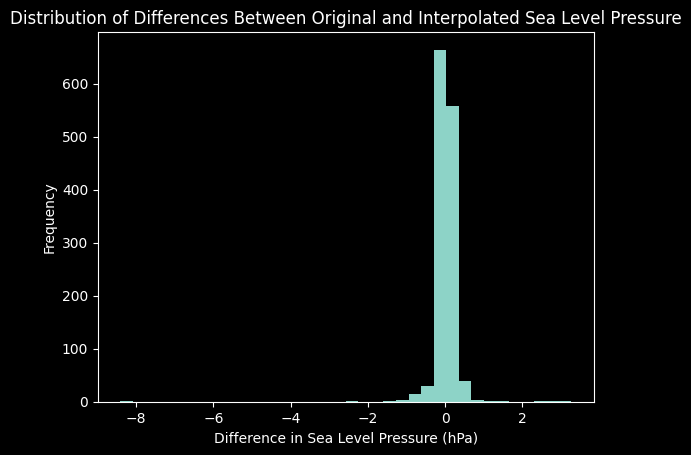

In [194]:
import matplotlib.pyplot as plt
import numpy as np

# Your DataFrame should be named, for example, 'usa_weather'
# and the column with the differences should be 'sea_level_pres_diff'

# Calculate number of bins using the Square Root Rule
num_bins = int(np.sqrt(len(annual_usa_weather_by_state_2['sea_level_pres_diff'].dropna())))

# Plot histogram of the differences
plt.hist(annual_usa_weather_by_state_2['sea_level_pres_diff'].dropna(), bins=num_bins)
plt.title('Distribution of Differences Between Original and Interpolated Sea Level Pressure')
plt.xlabel('Difference in Sea Level Pressure (hPa)')
plt.ylabel('Frequency')
plt.show()


In [178]:
# Find rows where the difference is at the extreme min and max
extreme_min_row = annual_usa_weather_by_state_2[annual_usa_weather_by_state_2['sea_level_pres_diff'] == annual_usa_weather_by_state_2['sea_level_pres_diff'].min()]
extreme_max_row = annual_usa_weather_by_state_2[annual_usa_weather_by_state_2['sea_level_pres_diff'] == annual_usa_weather_by_state_2['sea_level_pres_diff'].max()]

extreme_min_row

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,avg_sea_level_pres_hpa_linear,latitude,longitude,sea_level_pres_diff,avg_sea_level_pres_hpa_diff
242,1995,Colorado,-5.51,2.61,17.57,403.50,1017.12,1025.53,39.74,-104.98,-8.41,-8.41


In [179]:
extreme_max_row

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,avg_sea_level_pres_hpa_linear,latitude,longitude,sea_level_pres_diff,avg_sea_level_pres_hpa_diff
1362,2018,Arkansas,24.75,11.66,21.52,1792.50,1017.47,1014.21,34.74,-92.33,3.27,3.27


In [180]:
# Get index of extreme values
extreme_min_index = extreme_min_row.index[0]
extreme_max_index = extreme_max_row.index[0]

# Look at surrounding rows
rows_around_min = annual_usa_weather_by_state_2.loc[extreme_min_index - 5:extreme_min_index + 5]
rows_around_max = annual_usa_weather_by_state_2.loc[extreme_max_index - 5:extreme_max_index + 5]

rows_around_min

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,avg_sea_level_pres_hpa_linear,latitude,longitude,sea_level_pres_diff,avg_sea_level_pres_hpa_diff
237,1995,Alabama,18.49,12.25,25.10,1144.20,1017.28,1017.16,32.36,-86.28,0.12,0.12
238,1995,Alaska,5.60,2.10,9.00,1180.70,NaN,1017.23,58.31,-134.42,NaN,NaN
239,1995,Arizona,23.56,16.87,30.11,241.70,1011.39,1011.39,33.54,-112.07,0.01,0.01
240,1995,Arkansas,12.70,11.65,22.18,940.10,NaN,1014.97,34.74,-92.33,NaN,NaN
241,1995,California,16.12,9.89,23.48,651.10,NaN,1019.14,38.58,-121.47,NaN,NaN
242,1995,Colorado,-5.51,2.61,17.57,403.50,1017.12,1025.53,39.74,-104.98,-8.41,-8.41
243,1995,Connecticut,10.37,4.48,16.16,1039.80,1016.01,1015.98,41.77,-72.68,0.02,0.02
244,1995,Delaware,12.55,7.36,17.82,1018.80,1016.73,1016.73,39.16,-75.52,-0.00,-0.00
245,1995,District of Columbia,14.25,9.60,19.31,1011.00,1017.12,1017.12,38.90,-77.01,-0.00,-0.00
246,1995,Florida,19.67,13.50,26.51,1331.20,1017.22,1017.22,30.45,-84.28,-0.00,-0.00


In [182]:
rows_around_max

,year,state,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_sea_level_pres_hpa,avg_sea_level_pres_hpa_linear,latitude,longitude,sea_level_pres_diff,avg_sea_level_pres_hpa_diff
1357,2017,Wisconsin,9.29,3.96,14.25,972.80,1016.52,1016.28,43.07,-89.40,0.23,0.23
1358,2017,Wyoming,9.13,2.01,16.21,386.10,1014.57,1014.70,41.14,-104.82,-0.13,-0.13
1359,2018,Alabama,19.01,13.36,25.46,1402.40,1018.75,1018.67,32.36,-86.28,0.08,0.08
1360,2018,Alaska,6.16,2.30,9.92,1420.10,1014.38,1014.38,58.31,-134.42,0.00,0.00
1361,2018,Arizona,24.75,18.21,31.22,236.20,1011.48,1011.47,33.54,-112.07,0.01,0.01
1362,2018,Arkansas,24.75,11.66,21.52,1792.50,1017.47,1014.21,34.74,-92.33,3.27,3.27
1363,2018,California,15.94,9.15,23.97,468.40,1014.70,1015.60,38.58,-121.47,-0.90,-0.90
1364,2018,Colorado,17.94,3.03,19.18,295.80,1016.29,1014.96,39.74,-104.98,1.34,1.34
1365,2018,Connecticut,10.87,5.53,16.24,1594.70,1017.95,1018.14,41.77,-72.68,-0.19,-0.19
1366,2018,Delaware,13.38,8.47,18.19,1559.90,NaN,1021.34,39.16,-75.52,NaN,NaN


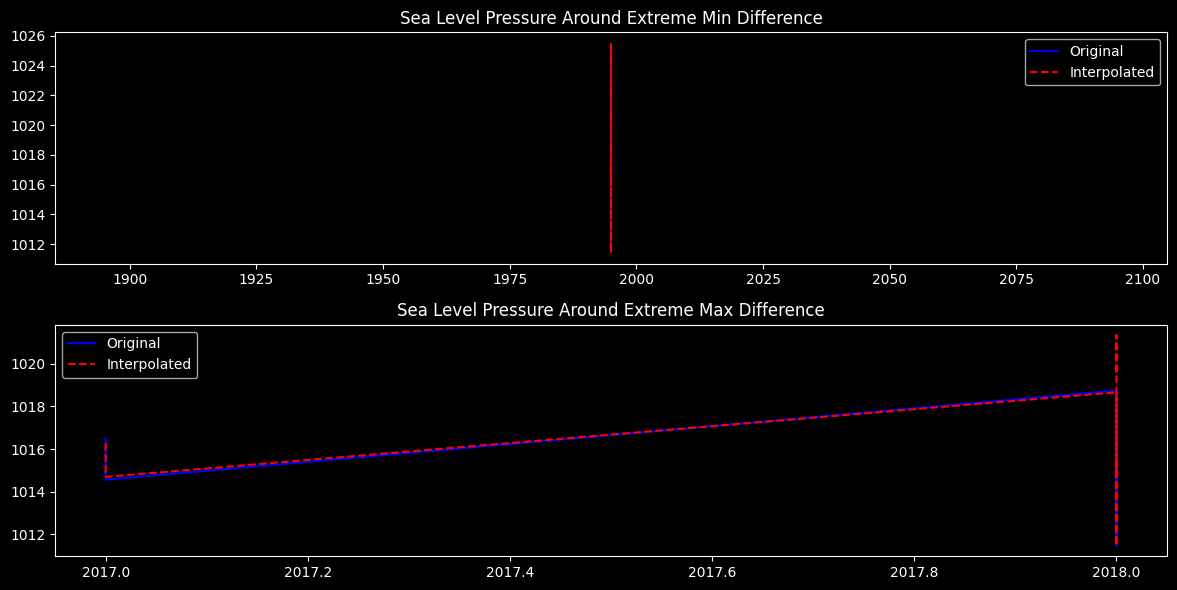

In [185]:
import matplotlib.pyplot as plt

# Plot the original and interpolated columns around the extreme min and max
plt.figure(figsize=(12, 6))

# First subplot for extreme min difference
plt.subplot(2, 1, 1)
plt.plot(rows_around_min['year'], rows_around_min['avg_sea_level_pres_hpa'], label='Original', color='b', linestyle='-')
plt.plot(rows_around_min['year'], rows_around_min['avg_sea_level_pres_hpa_linear'], label='Interpolated', color='r', linestyle='--')
plt.title('Sea Level Pressure Around Extreme Min Difference')
plt.legend()

# Second subplot for extreme max difference
plt.subplot(2, 1, 2)
plt.plot(rows_around_max['year'], rows_around_max['avg_sea_level_pres_hpa'], label='Original', color='b', linestyle='-')
plt.plot(rows_around_max['year'], rows_around_max['avg_sea_level_pres_hpa_linear'], label='Interpolated', color='r', linestyle='--')
plt.title('Sea Level Pressure Around Extreme Max Difference')
plt.legend()

plt.tight_layout()
plt.show()


In [195]:
# Handle missing values for `avg_sea_level_pres_hpa` column utilizing linear interpolation
usa_weather['avg_sea_level_pres_hpa_ffill'] = usa_weather['avg_sea_level_pres_hpa'].ffill()

usa_weather.isnull().sum()

station_id                           0
city_name                            0
date                                 0
avg_temp_c                           0
min_temp_c                           0
max_temp_c                           0
precipitation_mm                     0
avg_sea_level_pres_hpa           96906
state                                0
iso3                                 0
latitude                             0
longitude                            0
year                                 0
avg_sea_level_pres_hpa_linear        0
avg_sea_level_pres_hpa_ffill         0
dtype: int64

In [196]:
# Group by 'year' and 'state', then aggregate the numerical columns
annual_usa_weather_by_state_2 = usa_weather.groupby(['year', 'state']).agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'mean',
    'max_temp_c': 'mean',
    'precipitation_mm': 'sum',
    'avg_sea_level_pres_hpa': 'mean',
    'avg_sea_level_pres_hpa_linear': 'mean',
    'avg_sea_level_pres_hpa_ffill': 'mean',
    'latitude': 'first',  # Assuming all latitudes are the same for a given year and state
    'longitude': 'first'  # Assuming all longitudes are the same for a given year and state
}).reset_index()

In [199]:
annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_ffill'].describe()

count   1457.00
mean    1016.90
std        2.32
min     1009.60
25%     1015.99
50%     1016.93
75%     1017.93
max     1030.40
Name: avg_sea_level_pres_hpa_ffill, dtype: float64

In [213]:
# Calculate the difference between the two columns
annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_diff_ffill'] = annual_usa_weather_by_state_2['avg_sea_level_pres_hpa'] - annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_ffill']

# Describe the difference to get basic statistics
annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_diff_ffill'].describe()

count   1319.00
mean      -0.00
std        0.40
min       -8.62
25%       -0.03
50%        0.01
75%        0.09
max        2.89
Name: avg_sea_level_pres_hpa_diff_ffill, dtype: float64

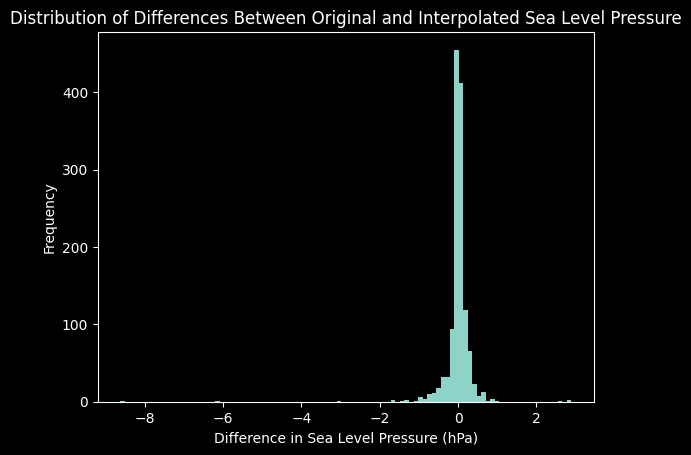

In [216]:
import matplotlib.pyplot as plt
import numpy as np

# Your DataFrame should be named, for example, 'usa_weather'
# and the column with the differences should be 'sea_level_pres_diff'

# # Calculate number of bins using the Square Root Rule
# num_bins = int(np.sqrt(len(annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_diff_ffill'].dropna())))

# Plot histogram of the differences
plt.hist(annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_diff_ffill'].dropna(), bins=100)
plt.title('Distribution of Differences Between Original and Interpolated Sea Level Pressure')
plt.xlabel('Difference in Sea Level Pressure (hPa)')
plt.ylabel('Frequency')
plt.show()


In [201]:
# Handle missing values for `avg_sea_level_pres_hpa` column utilizing linear interpolation
usa_weather['avg_sea_level_pres_hpa_bfill'] = usa_weather['avg_sea_level_pres_hpa'].bfill()

usa_weather.isnull().sum()

station_id                           0
city_name                            0
date                                 0
avg_temp_c                           0
min_temp_c                           0
max_temp_c                           0
precipitation_mm                     0
avg_sea_level_pres_hpa           96906
state                                0
iso3                                 0
latitude                             0
longitude                            0
year                                 0
avg_sea_level_pres_hpa_linear        0
avg_sea_level_pres_hpa_ffill         0
avg_sea_level_pres_hpa_bfill         0
dtype: int64

In [203]:
# Group by 'year' and 'state', then aggregate the numerical columns
annual_usa_weather_by_state_2 = usa_weather.groupby(['year', 'state']).agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'mean',
    'max_temp_c': 'mean',
    'precipitation_mm': 'sum',
    'avg_sea_level_pres_hpa': 'mean',
    'avg_sea_level_pres_hpa_linear': 'mean',
    'avg_sea_level_pres_hpa_ffill': 'mean',
    'avg_sea_level_pres_hpa_bfill': 'mean',
    'latitude': 'first',  # Assuming all latitudes are the same for a given year and state
    'longitude': 'first'  # Assuming all longitudes are the same for a given year and state
}).reset_index()

In [204]:
annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_bfill'].describe()

count   1457.00
mean    1016.73
std        2.12
min     1009.83
25%     1015.83
50%     1016.87
75%     1017.84
max     1034.80
Name: avg_sea_level_pres_hpa_bfill, dtype: float64

In [205]:
# Calculate the difference between the two columns
annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_diff_bfill'] = annual_usa_weather_by_state_2['avg_sea_level_pres_hpa'] - annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_bfill']

# Describe the difference to get basic statistics
annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_diff_bfill'].describe()

count   1319.00
mean       0.06
std        0.34
min       -2.74
25%       -0.02
50%        0.02
75%        0.13
max        3.29
Name: avg_sea_level_pres_hpa_diff_bfill, dtype: float64

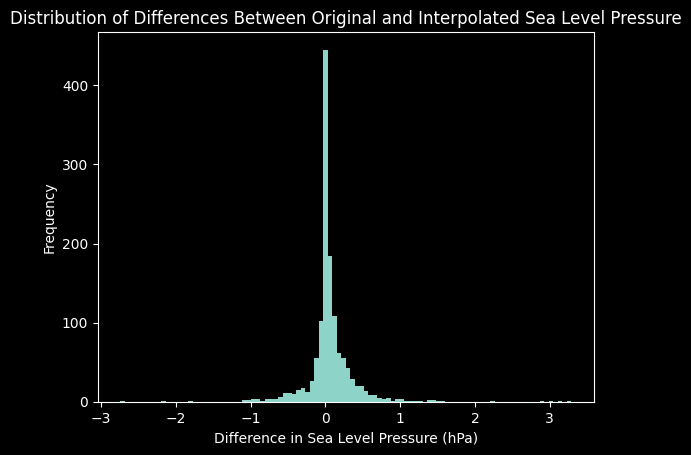

In [217]:
import matplotlib.pyplot as plt
import numpy as np

# Your DataFrame should be named, for example, 'usa_weather'
# and the column with the differences should be 'sea_level_pres_diff'

# # Calculate number of bins using the Square Root Rule
# num_bins = int(np.sqrt(len(annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_diff_ffill'].dropna())))

# Plot histogram of the differences
plt.hist(annual_usa_weather_by_state_2['avg_sea_level_pres_hpa_diff_bfill'].dropna(), bins=100)
plt.title('Distribution of Differences Between Original and Interpolated Sea Level Pressure')
plt.xlabel('Difference in Sea Level Pressure (hPa)')
plt.ylabel('Frequency')
plt.show()

### 5.6 Join Migraine Data with Weather Data

Finally, join the migraine data with the combined weather data (countries, cities, daily weather) on the `city_name` column from weather data and on the `location_name` column from the migraine data.

In [ ]:
# Combine USA combined weather with migraine data
usa_weather_migraine = usa_weather_bfill.merge(migraine_data, 
                                      how='left', 
                                      left_on='city_name', 
                                      right_on='location_name'
                                      )

# Review the shape of the new dataframe
usa_weather_migraine.shape

## 6. Feature Engineering

Discussing any new features that were created and why they were created. Also, discuss any features that were dropped and why they were dropped.

In [ ]:
# Code for feature engineering


## 7. Summary

Summarize the data preprocessing steps that were taken in this notebook.

## 8. Next Steps

Discuss any next steps that should be taken in the data analysis process/modeling phases.